In [2]:
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import cv2
import requests
from matplotlib import rcParams
import matplotlib.pyplot as plt

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

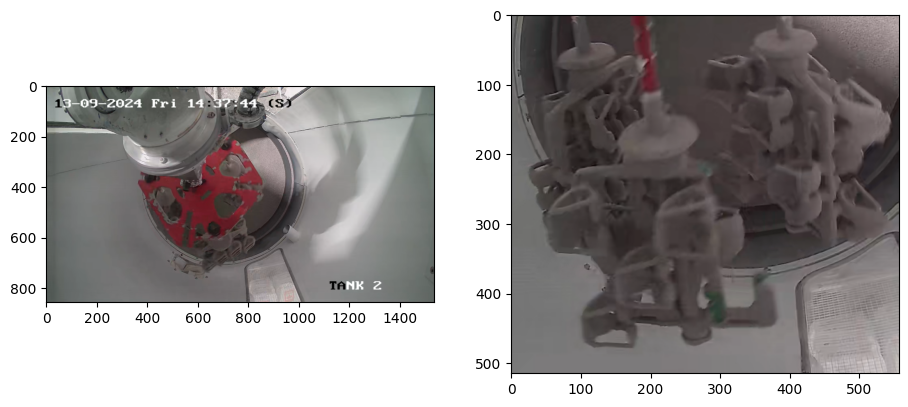

In [14]:



# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
image = Image.open('reference3.png').convert("RGB")
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_image = Image.open('sample1.png').convert("RGB")

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [15]:
# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [16]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


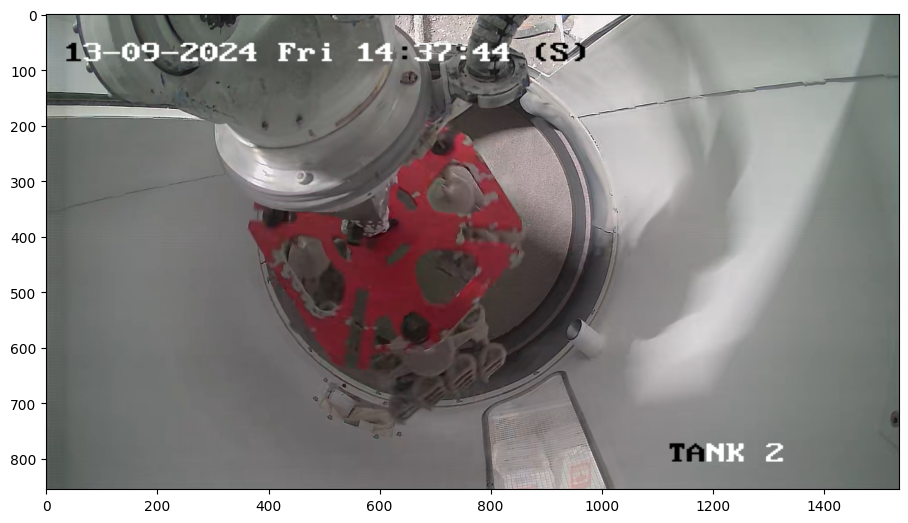

In [17]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

plt.imshow(img[:,:,::-1])

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model and processor
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

# Load the reference image (query image)
ref_image = Image.open('sample1.png').convert("RGB")

# Initialize video capture
video_path = 'input_video.mp4'  # Replace with your video path or 0 for webcam
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video file")

# Get video properties for output setup
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize video writer
output_path = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop if no more frames

    # Convert frame to PIL Image (from BGR to RGB)
    pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Prepare inputs for the model
    inputs = processor(images=pil_frame, query_images=ref_image, return_tensors="pt").to(device)

    # Perform object detection
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)

    # Move outputs to CPU for post-processing
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

    # Prepare target sizes tensor for post-processing
    h, w = frame.shape[:2]
    target_sizes = torch.Tensor([[h, w]])

    # Post-process the results
    results = processor.post_process_image_guided_detection(
        outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes
    )
    boxes = results[0]["boxes"]
    scores = results[0]["scores"]

    # Draw bounding boxes and scores on the frame
    for box, score in zip(boxes, scores):
        box = [int(coord) for coord in box.tolist()]
        # Draw red rectangle (BGR color format)
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 5)
        # Display score above the box
        cv2.putText(frame, f"{score:.2f}", (box[0], box[1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Write the processed frame to output video
    out.write(frame)

    # Optional: Display the frame
    cv2.imshow('Object Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()